# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8232
Epoch 1/200, Iteration 2/12, Loss: 0.5107
Epoch 1/200, Iteration 3/12, Loss: 0.7813
Epoch 1/200, Iteration 4/12, Loss: 0.6512
Epoch 1/200, Iteration 5/12, Loss: 0.3406
Epoch 1/200, Iteration 6/12, Loss: 0.4704
Epoch 1/200, Iteration 7/12, Loss: 0.4381
Epoch 1/200, Iteration 8/12, Loss: 0.3749
Epoch 1/200, Iteration 9/12, Loss: 0.2963
Epoch 1/200, Iteration 10/12, Loss: 0.2689
Epoch 1/200, Iteration 11/12, Loss: 0.2635
Epoch 1/200, Iteration 12/12, Loss: 0.2880
Epoch 1/200, Iteration 13/12, Loss: 0.2630
Train Error: 
 Accuracy: 59.25%, Avg loss: 0.271916, MRE: 0.182111, MAE: 0.038287 

Test Error: 
 Accuracy: 65.0%, Avg loss: 0.265365, MRE: 0.169289, MAE: 0.037990 

Epoch 2/200, Iteration 1/12, Loss: 0.2590
Epoch 2/200, Iteration 2/12, Loss: 0.2176
Epoch 2/200, Iteration 3/12, Loss: 0.2184
Epoch 2/200, Iteration 4/12, Loss: 0.2245
Epoch 2/200, Iteration 5/12, Loss: 0.2468
Epoch 2/200, Iteration 6/12, Loss: 0.2550
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.057201, MRE: 0.041204, MAE: 0.007559 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.059020, MRE: 0.034182, MAE: 0.007836 

Epoch 13/200, Iteration 1/12, Loss: 0.0602
Epoch 13/200, Iteration 2/12, Loss: 0.0559
Epoch 13/200, Iteration 3/12, Loss: 0.0466
Epoch 13/200, Iteration 4/12, Loss: 0.1188
Epoch 13/200, Iteration 5/12, Loss: 0.0780
Epoch 13/200, Iteration 6/12, Loss: 0.0748
Epoch 13/200, Iteration 7/12, Loss: 0.0625
Epoch 13/200, Iteration 8/12, Loss: 0.0576
Epoch 13/200, Iteration 9/12, Loss: 0.0457
Epoch 13/200, Iteration 10/12, Loss: 0.0756
Epoch 13/200, Iteration 11/12, Loss: 0.0875
Epoch 13/200, Iteration 12/12, Loss: 0.0576
Epoch 13/200, Iteration 13/12, Loss: 0.0749
Train Error: 
 Accuracy: 67.88%, Avg loss: 0.067691, MRE: 0.067302, MAE: 0.007606 

Test Error: 
 Accuracy: 65.5%, Avg loss: 0.066449, MRE: 0.059451, MAE: 0.007331 

Epoch 14/200, Iteration 1/12, Loss: 0.0556
Epoch 14/200, Iteration 2/12, Loss: 0.0851
Epoch 14/200, Iterat

Train Error: 
 Accuracy: 88.62%, Avg loss: 0.061505, MRE: 0.052766, MAE: 0.007923 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.049921, MRE: 0.038737, MAE: 0.006611 

Epoch 25/200, Iteration 1/12, Loss: 0.0722
Epoch 25/200, Iteration 2/12, Loss: 0.0619
Epoch 25/200, Iteration 3/12, Loss: 0.0505
Epoch 25/200, Iteration 4/12, Loss: 0.0679
Epoch 25/200, Iteration 5/12, Loss: 0.0567
Epoch 25/200, Iteration 6/12, Loss: 0.0474
Epoch 25/200, Iteration 7/12, Loss: 0.0601
Epoch 25/200, Iteration 8/12, Loss: 0.0514
Epoch 25/200, Iteration 9/12, Loss: 0.0508
Epoch 25/200, Iteration 10/12, Loss: 0.0484
Epoch 25/200, Iteration 11/12, Loss: 0.0728
Epoch 25/200, Iteration 12/12, Loss: 0.0922
Epoch 25/200, Iteration 13/12, Loss: 0.0511
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.062743, MRE: 0.041758, MAE: 0.007805 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.056450, MRE: 0.032471, MAE: 0.006972 

Epoch 26/200, Iteration 1/12, Loss: 0.0518
Epoch 26/200, Iteration 2/12, Loss: 0.0712
Epoch 26/200, Itera

Train Error: 
 Accuracy: 87.12%, Avg loss: 0.047033, MRE: 0.032198, MAE: 0.005729 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.046954, MRE: 0.030292, MAE: 0.005788 

Epoch 37/200, Iteration 1/12, Loss: 0.0379
Epoch 37/200, Iteration 2/12, Loss: 0.0448
Epoch 37/200, Iteration 3/12, Loss: 0.0592
Epoch 37/200, Iteration 4/12, Loss: 0.0525
Epoch 37/200, Iteration 5/12, Loss: 0.0436
Epoch 37/200, Iteration 6/12, Loss: 0.0550
Epoch 37/200, Iteration 7/12, Loss: 0.0382
Epoch 37/200, Iteration 8/12, Loss: 0.0492
Epoch 37/200, Iteration 9/12, Loss: 0.0630
Epoch 37/200, Iteration 10/12, Loss: 0.0364
Epoch 37/200, Iteration 11/12, Loss: 0.0473
Epoch 37/200, Iteration 12/12, Loss: 0.0561
Epoch 37/200, Iteration 13/12, Loss: 0.0421
Train Error: 
 Accuracy: 91.25%, Avg loss: 0.062300, MRE: 0.051353, MAE: 0.008309 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.053604, MRE: 0.043229, MAE: 0.007078 

Epoch 38/200, Iteration 1/12, Loss: 0.0558
Epoch 38/200, Iteration 2/12, Loss: 0.0641
Epoch 38/200, Itera

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.046564, MRE: 0.034480, MAE: 0.006629 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.046116, MRE: 0.030795, MAE: 0.006633 

Epoch 49/200, Iteration 1/12, Loss: 0.0396
Epoch 49/200, Iteration 2/12, Loss: 0.0459
Epoch 49/200, Iteration 3/12, Loss: 0.0481
Epoch 49/200, Iteration 4/12, Loss: 0.0369
Epoch 49/200, Iteration 5/12, Loss: 0.0521
Epoch 49/200, Iteration 6/12, Loss: 0.0452
Epoch 49/200, Iteration 7/12, Loss: 0.0466
Epoch 49/200, Iteration 8/12, Loss: 0.0487
Epoch 49/200, Iteration 9/12, Loss: 0.0530
Epoch 49/200, Iteration 10/12, Loss: 0.0396
Epoch 49/200, Iteration 11/12, Loss: 0.0428
Epoch 49/200, Iteration 12/12, Loss: 0.0389
Epoch 49/200, Iteration 13/12, Loss: 0.0438
Train Error: 
 Accuracy: 84.75%, Avg loss: 0.044651, MRE: 0.035570, MAE: 0.005708 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.037987, MRE: 0.022770, MAE: 0.004889 

Epoch 50/200, Iteration 1/12, Loss: 0.0504
Epoch 50/200, Iteration 2/12, Loss: 0.0508
Epoch 50/200, Itera

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.059469, MRE: 0.044406, MAE: 0.008999 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.057736, MRE: 0.035330, MAE: 0.008682 

Epoch 61/200, Iteration 1/12, Loss: 0.0560
Epoch 61/200, Iteration 2/12, Loss: 0.0616
Epoch 61/200, Iteration 3/12, Loss: 0.0478
Epoch 61/200, Iteration 4/12, Loss: 0.0468
Epoch 61/200, Iteration 5/12, Loss: 0.0370
Epoch 61/200, Iteration 6/12, Loss: 0.0372
Epoch 61/200, Iteration 7/12, Loss: 0.0418
Epoch 61/200, Iteration 8/12, Loss: 0.0454
Epoch 61/200, Iteration 9/12, Loss: 0.0551
Epoch 61/200, Iteration 10/12, Loss: 0.0447
Epoch 61/200, Iteration 11/12, Loss: 0.0527
Epoch 61/200, Iteration 12/12, Loss: 0.0353
Epoch 61/200, Iteration 13/12, Loss: 0.0535
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.048603, MRE: 0.036083, MAE: 0.005928 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.047409, MRE: 0.034177, MAE: 0.005540 

Epoch 62/200, Iteration 1/12, Loss: 0.0500
Epoch 62/200, Iteration 2/12, Loss: 0.0477
Epoch 62/200, Itera

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.005841, MRE: 0.011154, MAE: 0.000750 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006230, MRE: 0.004408, MAE: 0.000787 

Epoch 73/200, Iteration 1/12, Loss: 0.0055
Epoch 73/200, Iteration 2/12, Loss: 0.0066
Epoch 73/200, Iteration 3/12, Loss: 0.0077
Epoch 73/200, Iteration 4/12, Loss: 0.0065
Epoch 73/200, Iteration 5/12, Loss: 0.0065
Epoch 73/200, Iteration 6/12, Loss: 0.0066
Epoch 73/200, Iteration 7/12, Loss: 0.0076
Epoch 73/200, Iteration 8/12, Loss: 0.0094
Epoch 73/200, Iteration 9/12, Loss: 0.0065
Epoch 73/200, Iteration 10/12, Loss: 0.0078
Epoch 73/200, Iteration 11/12, Loss: 0.0092
Epoch 73/200, Iteration 12/12, Loss: 0.0074
Epoch 73/200, Iteration 13/12, Loss: 0.0066
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.007645, MRE: 0.011788, MAE: 0.000998 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007710, MRE: 0.005124, MAE: 0.001022 

Epoch 74/200, Iteration 1/12, Loss: 0.0080
Epoch 74/200, Iteration 2/12, Loss: 0.0092
Epoch 74/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004790, MRE: 0.007136, MAE: 0.000635 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005233, MRE: 0.003659, MAE: 0.000684 

Epoch 85/200, Iteration 1/12, Loss: 0.0049
Epoch 85/200, Iteration 2/12, Loss: 0.0046
Epoch 85/200, Iteration 3/12, Loss: 0.0043
Epoch 85/200, Iteration 4/12, Loss: 0.0053
Epoch 85/200, Iteration 5/12, Loss: 0.0043
Epoch 85/200, Iteration 6/12, Loss: 0.0050
Epoch 85/200, Iteration 7/12, Loss: 0.0041
Epoch 85/200, Iteration 8/12, Loss: 0.0056
Epoch 85/200, Iteration 9/12, Loss: 0.0040
Epoch 85/200, Iteration 10/12, Loss: 0.0045
Epoch 85/200, Iteration 11/12, Loss: 0.0053
Epoch 85/200, Iteration 12/12, Loss: 0.0040
Epoch 85/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004673, MRE: 0.010793, MAE: 0.000603 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005281, MRE: 0.003796, MAE: 0.000673 

Epoch 86/200, Iteration 1/12, Loss: 0.0041
Epoch 86/200, Iteration 2/12, Loss: 0.0050
Epoch 86/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003974, MRE: 0.006451, MAE: 0.000509 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004775, MRE: 0.003462, MAE: 0.000597 

Epoch 97/200, Iteration 1/12, Loss: 0.0048
Epoch 97/200, Iteration 2/12, Loss: 0.0038
Epoch 97/200, Iteration 3/12, Loss: 0.0042
Epoch 97/200, Iteration 4/12, Loss: 0.0037
Epoch 97/200, Iteration 5/12, Loss: 0.0039
Epoch 97/200, Iteration 6/12, Loss: 0.0038
Epoch 97/200, Iteration 7/12, Loss: 0.0036
Epoch 97/200, Iteration 8/12, Loss: 0.0044
Epoch 97/200, Iteration 9/12, Loss: 0.0034
Epoch 97/200, Iteration 10/12, Loss: 0.0059
Epoch 97/200, Iteration 11/12, Loss: 0.0041
Epoch 97/200, Iteration 12/12, Loss: 0.0038
Epoch 97/200, Iteration 13/12, Loss: 0.0036
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004050, MRE: 0.006685, MAE: 0.000525 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004751, MRE: 0.003451, MAE: 0.000602 

Epoch 98/200, Iteration 1/12, Loss: 0.0040
Epoch 98/200, Iteration 2/12, Loss: 0.0050
Epoch 98/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003774, MRE: 0.006377, MAE: 0.000486 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004469, MRE: 0.003219, MAE: 0.000567 

Epoch 109/200, Iteration 1/12, Loss: 0.0035
Epoch 109/200, Iteration 2/12, Loss: 0.0034
Epoch 109/200, Iteration 3/12, Loss: 0.0032
Epoch 109/200, Iteration 4/12, Loss: 0.0040
Epoch 109/200, Iteration 5/12, Loss: 0.0041
Epoch 109/200, Iteration 6/12, Loss: 0.0038
Epoch 109/200, Iteration 7/12, Loss: 0.0041
Epoch 109/200, Iteration 8/12, Loss: 0.0041
Epoch 109/200, Iteration 9/12, Loss: 0.0045
Epoch 109/200, Iteration 10/12, Loss: 0.0032
Epoch 109/200, Iteration 11/12, Loss: 0.0055
Epoch 109/200, Iteration 12/12, Loss: 0.0034
Epoch 109/200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003798, MRE: 0.006420, MAE: 0.000493 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004481, MRE: 0.003254, MAE: 0.000571 

Epoch 110/200, Iteration 1/12, Loss: 0.0036
Epoch 110/200, Iteration 2/12, Loss: 0.0036
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003748, MRE: 0.006316, MAE: 0.000481 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004496, MRE: 0.003249, MAE: 0.000565 

Epoch 121/200, Iteration 1/12, Loss: 0.0035
Epoch 121/200, Iteration 2/12, Loss: 0.0034
Epoch 121/200, Iteration 3/12, Loss: 0.0031
Epoch 121/200, Iteration 4/12, Loss: 0.0042
Epoch 121/200, Iteration 5/12, Loss: 0.0050
Epoch 121/200, Iteration 6/12, Loss: 0.0028
Epoch 121/200, Iteration 7/12, Loss: 0.0035
Epoch 121/200, Iteration 8/12, Loss: 0.0039
Epoch 121/200, Iteration 9/12, Loss: 0.0041
Epoch 121/200, Iteration 10/12, Loss: 0.0040
Epoch 121/200, Iteration 11/12, Loss: 0.0031
Epoch 121/200, Iteration 12/12, Loss: 0.0038
Epoch 121/200, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003885, MRE: 0.006287, MAE: 0.000500 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004484, MRE: 0.003289, MAE: 0.000570 

Epoch 122/200, Iteration 1/12, Loss: 0.0036
Epoch 122/200, Iteration 2/12, Loss: 0.0039
Ep

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004341, MRE: 0.003068, MAE: 0.000551 

Epoch 132/200, Iteration 1/12, Loss: 0.0046
Epoch 132/200, Iteration 2/12, Loss: 0.0030
Epoch 132/200, Iteration 3/12, Loss: 0.0037
Epoch 132/200, Iteration 4/12, Loss: 0.0038
Epoch 132/200, Iteration 5/12, Loss: 0.0034
Epoch 132/200, Iteration 6/12, Loss: 0.0046
Epoch 132/200, Iteration 7/12, Loss: 0.0030
Epoch 132/200, Iteration 8/12, Loss: 0.0029
Epoch 132/200, Iteration 9/12, Loss: 0.0052
Epoch 132/200, Iteration 10/12, Loss: 0.0030
Epoch 132/200, Iteration 11/12, Loss: 0.0026
Epoch 132/200, Iteration 12/12, Loss: 0.0033
Epoch 132/200, Iteration 13/12, Loss: 0.0037
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003536, MRE: 0.005937, MAE: 0.000452 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004266, MRE: 0.003029, MAE: 0.000539 

Epoch 133/200, Iteration 1/12, Loss: 0.0031
Epoch 133/200, Iteration 2/12, Loss: 0.0036
Epoch 133/200, Iteration 3/12, Loss: 0.0034
Epoch 133/200, Iteration 4/12, Loss: 0.004

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003402, MRE: 0.005829, MAE: 0.000441 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004190, MRE: 0.003000, MAE: 0.000534 

Epoch 144/200, Iteration 1/12, Loss: 0.0030
Epoch 144/200, Iteration 2/12, Loss: 0.0049
Epoch 144/200, Iteration 3/12, Loss: 0.0039
Epoch 144/200, Iteration 4/12, Loss: 0.0033
Epoch 144/200, Iteration 5/12, Loss: 0.0036
Epoch 144/200, Iteration 6/12, Loss: 0.0037
Epoch 144/200, Iteration 7/12, Loss: 0.0036
Epoch 144/200, Iteration 8/12, Loss: 0.0030
Epoch 144/200, Iteration 9/12, Loss: 0.0034
Epoch 144/200, Iteration 10/12, Loss: 0.0039
Epoch 144/200, Iteration 11/12, Loss: 0.0035
Epoch 144/200, Iteration 12/12, Loss: 0.0036
Epoch 144/200, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003339, MRE: 0.005943, MAE: 0.000435 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004063, MRE: 0.002889, MAE: 0.000516 

Epoch 145/200, Iteration 1/12, Loss: 0.0037
Epoch 145/200, Iteration 2/12, Loss: 0.0026
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003304, MRE: 0.005898, MAE: 0.000424 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003918, MRE: 0.002822, MAE: 0.000500 

Epoch 156/200, Iteration 1/12, Loss: 0.0030
Epoch 156/200, Iteration 2/12, Loss: 0.0032
Epoch 156/200, Iteration 3/12, Loss: 0.0044
Epoch 156/200, Iteration 4/12, Loss: 0.0027
Epoch 156/200, Iteration 5/12, Loss: 0.0033
Epoch 156/200, Iteration 6/12, Loss: 0.0039
Epoch 156/200, Iteration 7/12, Loss: 0.0034
Epoch 156/200, Iteration 8/12, Loss: 0.0034
Epoch 156/200, Iteration 9/12, Loss: 0.0031
Epoch 156/200, Iteration 10/12, Loss: 0.0034
Epoch 156/200, Iteration 11/12, Loss: 0.0034
Epoch 156/200, Iteration 12/12, Loss: 0.0037
Epoch 156/200, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003286, MRE: 0.005637, MAE: 0.000430 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004053, MRE: 0.002942, MAE: 0.000519 

Epoch 157/200, Iteration 1/12, Loss: 0.0034
Epoch 157/200, Iteration 2/12, Loss: 0.0046
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003103, MRE: 0.005492, MAE: 0.000402 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003861, MRE: 0.002713, MAE: 0.000490 

Epoch 168/200, Iteration 1/12, Loss: 0.0027
Epoch 168/200, Iteration 2/12, Loss: 0.0029
Epoch 168/200, Iteration 3/12, Loss: 0.0032
Epoch 168/200, Iteration 4/12, Loss: 0.0030
Epoch 168/200, Iteration 5/12, Loss: 0.0027
Epoch 168/200, Iteration 6/12, Loss: 0.0033
Epoch 168/200, Iteration 7/12, Loss: 0.0024
Epoch 168/200, Iteration 8/12, Loss: 0.0048
Epoch 168/200, Iteration 9/12, Loss: 0.0030
Epoch 168/200, Iteration 10/12, Loss: 0.0032
Epoch 168/200, Iteration 11/12, Loss: 0.0042
Epoch 168/200, Iteration 12/12, Loss: 0.0028
Epoch 168/200, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003142, MRE: 0.005531, MAE: 0.000410 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003862, MRE: 0.002670, MAE: 0.000490 

Epoch 169/200, Iteration 1/12, Loss: 0.0021
Epoch 169/200, Iteration 2/12, Loss: 0.0031
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003081, MRE: 0.005542, MAE: 0.000403 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003733, MRE: 0.002543, MAE: 0.000480 

Epoch 180/200, Iteration 1/12, Loss: 0.0028
Epoch 180/200, Iteration 2/12, Loss: 0.0036
Epoch 180/200, Iteration 3/12, Loss: 0.0032
Epoch 180/200, Iteration 4/12, Loss: 0.0029
Epoch 180/200, Iteration 5/12, Loss: 0.0031
Epoch 180/200, Iteration 6/12, Loss: 0.0029
Epoch 180/200, Iteration 7/12, Loss: 0.0038
Epoch 180/200, Iteration 8/12, Loss: 0.0027
Epoch 180/200, Iteration 9/12, Loss: 0.0026
Epoch 180/200, Iteration 10/12, Loss: 0.0025
Epoch 180/200, Iteration 11/12, Loss: 0.0043
Epoch 180/200, Iteration 12/12, Loss: 0.0031
Epoch 180/200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003104, MRE: 0.005444, MAE: 0.000400 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003582, MRE: 0.002528, MAE: 0.000461 

Epoch 181/200, Iteration 1/12, Loss: 0.0030
Epoch 181/200, Iteration 2/12, Loss: 0.0040
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.002844, MRE: 0.005234, MAE: 0.000372 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003545, MRE: 0.002490, MAE: 0.000455 

Epoch 192/200, Iteration 1/12, Loss: 0.0029
Epoch 192/200, Iteration 2/12, Loss: 0.0028
Epoch 192/200, Iteration 3/12, Loss: 0.0030
Epoch 192/200, Iteration 4/12, Loss: 0.0029
Epoch 192/200, Iteration 5/12, Loss: 0.0031
Epoch 192/200, Iteration 6/12, Loss: 0.0040
Epoch 192/200, Iteration 7/12, Loss: 0.0032
Epoch 192/200, Iteration 8/12, Loss: 0.0026
Epoch 192/200, Iteration 9/12, Loss: 0.0029
Epoch 192/200, Iteration 10/12, Loss: 0.0034
Epoch 192/200, Iteration 11/12, Loss: 0.0026
Epoch 192/200, Iteration 12/12, Loss: 0.0029
Epoch 192/200, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003050, MRE: 0.005287, MAE: 0.000395 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003540, MRE: 0.002511, MAE: 0.000459 

Epoch 193/200, Iteration 1/12, Loss: 0.0033
Epoch 193/200, Iteration 2/12, Loss: 0.0028
Ep

#### Plots loss vs Epoch

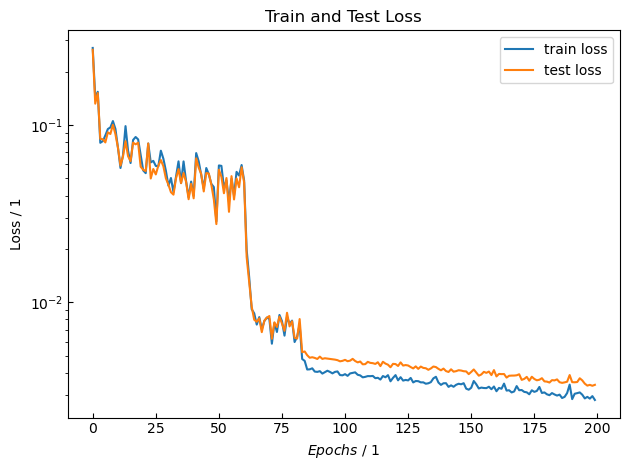

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_005_012.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999783687601872 , R^2(NH3) = 0.9999609474324713
Test Dataset: R^2(H2) = 0.9999768424601769 , R^2(NH3) = 0.9999603614578518
Max Error Training: |x_H2 - x_H2,pred| = 0.01537650066030849 , |x_NH3 - x_NH3,pred| = 0.0071674552456669205
Max Error Test: |x_H2 - x_H2,pred| = 0.003523774939460156 , |x_NH3 - x_NH3,pred| = 0.003152748355607804


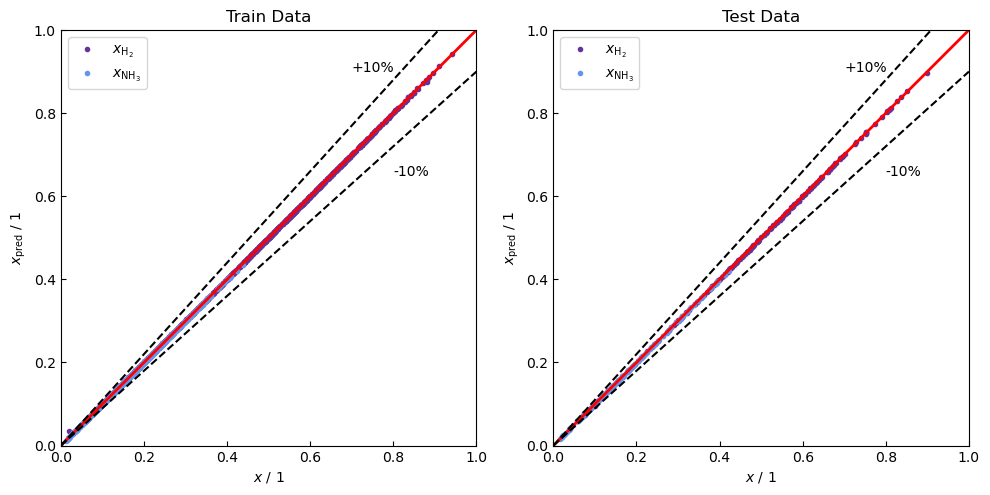

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

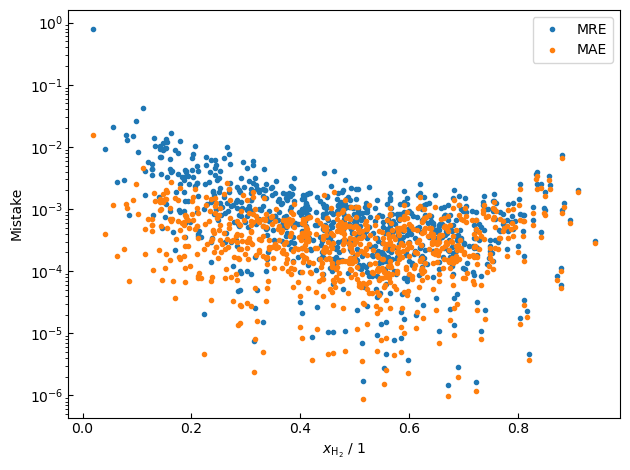

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

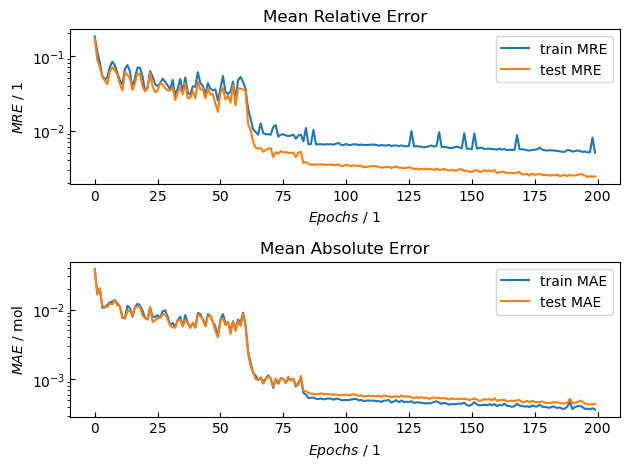

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

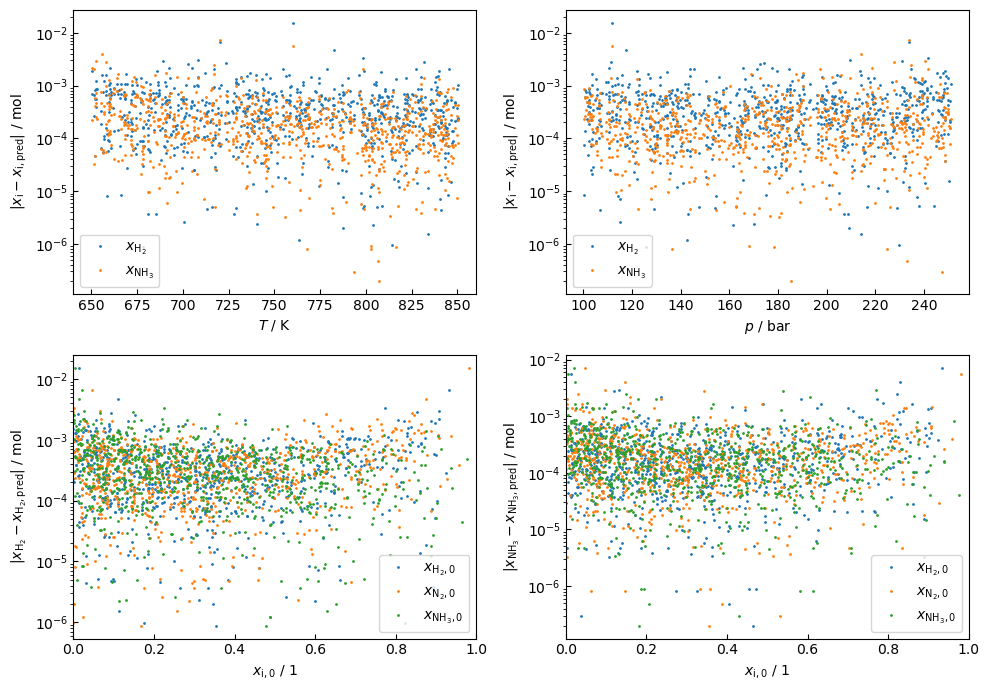

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

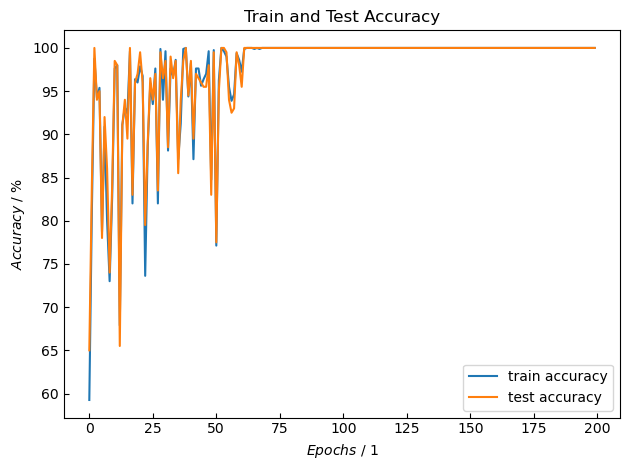

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 1.2716e+00,  1.2730e-01, -5.1956e-01, -1.0607e+00,  1.5940e+00],
        [-1.7763e-01,  7.5343e-01, -5.2777e-02, -9.1972e-01,  9.9182e-01],
        [ 1.1448e+00,  2.3708e-02,  1.2820e+00, -8.4604e-01, -3.9344e-01],
        [-1.0850e+00,  1.4037e+00,  1.1394e-01,  1.0708e+00, -1.2062e+00],
        [-1.3180e+00, -1.2691e+00, -9.5714e-01,  9.2436e-01, -5.4451e-03],
        [-9.3532e-01, -1.3773e+00,  8.4218e-01, -4.7557e-01, -3.4044e-01],
        [-3.7241e-01,  1.2186e+00,  3.5816e-02,  1.3761e-01, -1.7580e-01],
        [ 9.9650e-01,  6.9499e-01,  1.2499e+00, -1.3299e+00,  1.3262e-01],
        [-1.1193e+00, -8.0417e-01, -7.0598e-01,  1.2467e+00, -5.8139e-01],
        [-9.9977e-01, -2.5661e-01,  2.9742e-01, -1.2619e-01, -1.6291e-01],
        [-1.2379e+00,  8.2670e-02,  1.6796e+00, -9.8962e-01, -6.3687e-01],
        [ 6.1143e-01, -8.4338e-01, -9.0042e-01, -1.3014e+00,  2.2137e+00],
        [ 8.5742e-01, -1.3616e+00,  1.5719e+00, -5.2933e-01, -1.0016e+00],
        [ 1.1851e-01, -1.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-2.4480e-01,  1.4660e-01, -8.0352e-02, -1.1732e-01,  9.2666e-02],
         [-1.2917e-01,  5.4283e-02, -1.7428e-01, -4.8221e-02, -2.3042e-01],
         [ 7.3255e-02,  5.1173e-02,  2.9400e-01, -1.6406e-01,  1.9398e-01],
         [ 9.6555e-03,  6.9565e-03, -1.5758e-02, -1.2048e-02, -2.6532e-02],
         [ 1.0122e-01, -1.1793e-01,  3.8863e-02,  2.5225e-01,  1.8102e-01],
         [ 2.8181e-01, -2.8785e-01,  1.8099e-01,  1.7478e-01,  2.5216e-01],
         [ 7.6095e-03, -7.6192e-02,  5.7158e-02,  1.7882e-01,  5.2385e-02],
         [-1.8034e-01, -6.8062e-02,  2.1991e-01,  4.1323e-01,  1.6250e-01],
         [-1.9911e-01,  8.7617e-03, -5.3028e-02,  2.0805e-01,  1.1500e-02],
         [-1.5015e-01,  4.1833e-02, -1.2224e-01,  1.6420e-01, -1.1130e-01],
         [-4.4264e-02,  2.8421e-02, -8.8289e-02, -3.0138e-02, -5.2360e-02],
         [ 1.0624e-01,  7.9146e-02,  2.7720e-01,  4.4600e-01,  3.3634e-02],
         [ 2.7420e-02, -1.4011e-01,  3.9191e-01, -4.1589e-01, -2.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1536, 0.2459, 0.6011, 0.5240, 0.0594],
        [0.5276, 0.9112, 0.5692, 0.2712, 0.4577]])
tensor([[-0.0722, -0.0146],
        [ 0.2018, -0.0129]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.2418,  0.5071,  0.6640, -0.7493,  0.1142],
        [ 1.5173, -0.7546,  0.2204, -0.6587,  0.4569],
        [-0.6673, -1.7169, -1.0734, -0.2769,  1.3364],
        [-0.9084, -1.2030,  1.6249, -0.5641, -1.0180],
        [-0.3368, -0.9129, -1.0964, -0.8584,  1.9534],
        [-0.8049, -1.4530, -1.4150, -0.2878,  1.6828],
        [ 0.1093, -0.2494,  1.4727, -0.1235, -1.3191],
        [-0.2806, -0.8661,  0.6571, -0.5221, -0.1112],
        [-0.5213, -0.4879, -1.3674,  0.1539,  1.1847],
        [ 0.1993, -0.4285,  0.7691, -0.3588, -0.3880],
        [ 0.9230, -0.1178, -1.1215,  0.9641,  0.1153],
        [-1.3782,  0.0969, -0.7142,  0.6954, -0.0098],
        [ 1.0444,  0.0678,  0.5252,  0.0972, -0.6148],
        [-0.1299,  0.7456, -0.8134, -0.0335,  0.8325],
        [ 0.9116, -0.3668,  0.0603, -0.1877,  0.1326],
        [-0.1101, -1.0523,  0.8482, -0.5137, -0.3073],
        [-0.1780, -1.2922, -0.9228, -0.1651,  1.0744],
        [-0.9353, -1.3773,  0.8422, -0.4756, -0.3404],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()